In [1]:
"""
Solve the differential equations for Earth/Sun orbits using scipy
Plot the result orbits using matplotlib
"""

import math
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
# Constant Definition - units are in kilograms, kilometers, and days
GRAV_CON = 4.981 * 10 ** (-10) 
MASS_SUN = 1.989 * 10 ** 30
MASS_EARTH = 5.977 * 10 ** 24
INIT_EARTH = (1.495979 * 10 ** 8, 0, 0, 2.56721625 * 10 ** 6)
ORBITS = {}

# Resource paths
DATA_PATH = "data/"
PLOTS_PATH = "plots/"


In [3]:
#########################################################################
# Part 1 -  Solve the orbital equations and plot the resulting orbits


def orbital_eqs(e_0, t_0):
    """
    Input: Tuple e_0 of floats that represent Earth's position (p_x, p_y)
    and velocity (v_x, v_y) at time t_0
    
    Output: Tuple that contains approximation to d(e)/dt,
    computed from the orbital equations
    
    NOTE: The variable t_0 is not used in computing the
    returned value for the orbital equations
    """
    p_x, p_y, v_x, v_y = e_0
    
    dpx_dt = v_x
    dpy_dt = v_y
    
    rad = ((p_x)**2 + (p_y)**2)**0.5
    
    dvx_dt = (-GRAV_CON*MASS_SUN)*p_x/(rad**3)
    dvy_dt = (-GRAV_CON*MASS_SUN)*p_y/(rad**3)
    
    return (dpx_dt, dpy_dt, dvx_dt, dvy_dt)

In [4]:
def solve_orbital_eqs(time_steps, speed=1.0):
    """
    Input: numpy array time_steps, optional float speed
    that scales the Earth's initial velocity
    
    Output: Returns a 2D numpy array whose rows are the
    x and y position of the Earth's orbit at specified times
    """
    (p_x0, p_y0, v_x0, v_y0) = INIT_EARTH
    scaled = (p_x0, p_y0, v_x0 * speed, v_y0 * speed)
    
    sol = (odeint(orbital_eqs, scaled, time_steps)).T
    
    return sol[:2]

In [5]:
def test_solve_orbital_eqs():
    """ Test solve_orbital_eqs() """
    
    # Small test
    solve_orbital_eqs(np.linspace(0, 1, 3), 1.0)
    solve_orbital_eqs(np.linspace(0, 1, 11), 1.00)
    solve_orbital_eqs(np.linspace(0, 10, 101), 0.5)

    # Compute Earth/Sun orbits and save for later
    sim_steps = np.linspace(0, 1000, 1001)
    ORBITS["075"] = solve_orbital_eqs(sim_steps, 0.75)
    ORBITS["100"] = solve_orbital_eqs(sim_steps, 1.00)
    ORBITS["125"] = solve_orbital_eqs(sim_steps, 1.25)
    ORBITS["150"] = solve_orbital_eqs(sim_steps, 1.50)

test_solve_orbital_eqs()

In [6]:
def plot_earth_coords(orbit, time_steps, title="(p_x(t),p_y(t)) plots"):
    """
    Input: Numpy array orbit whose rows are numpy arrays containing x and y positions
    for the Earth orbit for specified times in the numpy array time_steps
    
    Action: Plot both x positions and y positions versus time_steps
    using matplotlib
    """

    fig, axs = plt.subplots()
    axs.plot(time_steps, orbit[0])
    axs.plot(time_steps, orbit[1])
    axs.set_title(title)
    axs.set_xlabel("Days")
    axs.set_ylabel("x and y positions in km (functions of time)")
    axs.legend(["x(t) function", "y(t) function"], loc= "lower left")
    
    return fig

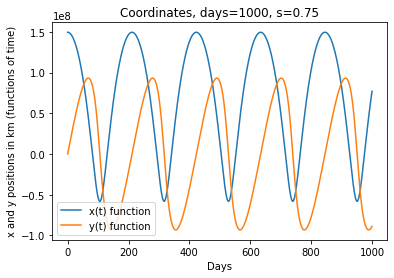

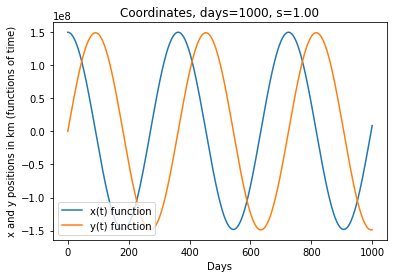

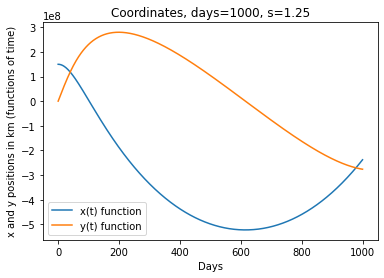

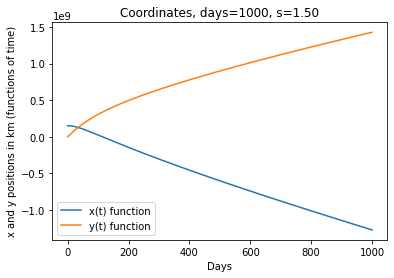

In [7]:
def test_plot_earth_coords():
    """ Test plot_earth_coords """
    
    sim_steps = np.linspace(0, 1000, 1001) 
    plot_earth_coords(ORBITS["075"], sim_steps, "Coordinates, days=1000, s=0.75")
    plot_earth_coords(ORBITS["100"], sim_steps, "Coordinates, days=1000, s=1.00")
    plot_earth_coords(ORBITS["125"], sim_steps, "Coordinates, days=1000, s=1.25")
    plot_earth_coords(ORBITS["150"], sim_steps, "Coordinates, days=1000, s=1.50")

test_plot_earth_coords()

In [8]:
def plot_earth_orbit(orbit, title="Plotted orbit"):
    """
    Input: Numpy array orbit whose rows are numpy arrays containing x and y positions
    for the Earth orbit
    
    Action: Plot x positions versus y positions using matplotlib
    """
    
    fig, axs = plt.subplots()
    axs.plot(orbit[0], orbit[1])
    axs.set_aspect(1)
    axs.set_title(title)
    axs.set_ylabel("y position (km)")
    axs.set_xlabel("x position (km)")
    
###include legend, and check if these plots are correct

    return fig

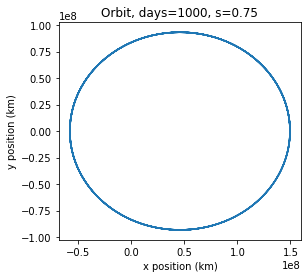

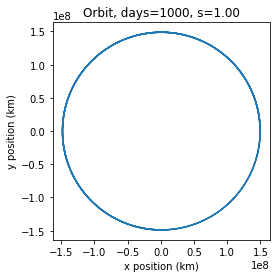

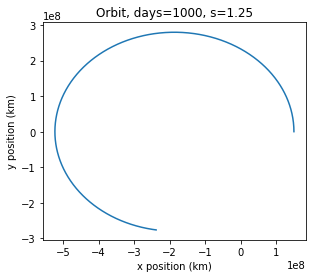

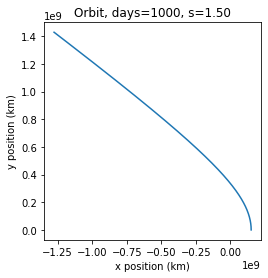

In [9]:
def test_plot_earth_orbit():
    """ Test plot_earth_orbit() """

    plot_earth_orbit(ORBITS["075"], "Orbit, days=1000, s=0.75")
    plot_earth_orbit(ORBITS["100"], "Orbit, days=1000, s=1.00")
    plot_earth_orbit(ORBITS["125"], "Orbit, days=1000, s=1.25")
    plot_earth_orbit(ORBITS["150"], "Orbit, days=1000, s=1.50")

test_plot_earth_orbit()

In [10]:
#########################################################################
# Part 2 - Animate the computed orbits


def extend_limits(limits, pad=0.1):
    """
    Input: Tuple limits = (min_x, max_x, min_y, max_y),
    float pad treated as a percentage

    Output: Tuple of four floats that represent new ranges
    extended by pad (as percentage of range length) in both directions
    """
    min_x, max_x, min_y, max_y = limits
    ext_x = (max_x - min_x + 1)*pad
    ext_y = (max_y - min_y + 1)*pad
    
    return (min_x - ext_x, max_x + ext_x, min_y - ext_y, max_y + ext_y)

In [11]:
def animate_earth_orbit(orbit, title="Animated orbit"):
    """
    Input: Numpy array orbit whose rows are numpy arrays containing x and y positions
    for the Earth orbit
    
    Output: matplotlib Animation object corresponding to
    plot of x positions versus y positions using matplotlib
    """
    extended_lims = extend_limits((np.max(orbit[0]), np.min(orbit[0]),
                                   np.max(orbit[1]), np.min(orbit[1])), pad=1.0)
    ext_min_x, ext_max_x, ext_min_y, ext_max_y = extended_lims
    
    def animate(frame):
        endidx = frame * len(orbit[0])//200
        
        if frame == 0:
            xvals, yvals = [],[]
            earth_x, earth_y = orbit[0][0], orbit[1][0]
        else:
            xvals = orbit[0][:endidx]
            yvals = orbit[1][:endidx]
            earth_x = orbit[0][endidx-1]
            earth_y = orbit[1][endidx-1]
        
        orbit_line.set_data(xvals, yvals)
        earth_disk.set_data([earth_x], [earth_y])
        
        return orbit_line, earth_disk

    fig, axs = plt.subplots()
    axs.set_xlim(ext_min_x, ext_max_x)
    axs.set_ylim(ext_min_y, ext_max_y)
    axs.set_aspect('equal')
    axs.set_xlabel('x position (km)')
    axs.set_ylabel('y position (km)')
    axs.set_title(title)
    
    axs.plot((0,0), 'yo', label='Sun', markersize=12)
    orbit_line, = axs.plot([],[], color="red", linestyle="-", lw = 1)
    earth_disk, = axs.plot([], [], color="blue", marker='o', linestyle='', markersize=10)
        
    anim = animation.FuncAnimation(fig, animate, init_func=lambda : animate(0),
                                   frames=200, interval=20, blit=True)
    
    if orbit.all():
        anim.save(orbit.all(), fps=30, extra_args=['-vcodec', 'libx264'])
        
    return anim

Creating animation for speed=0.75


<IPython.core.display.Javascript object>


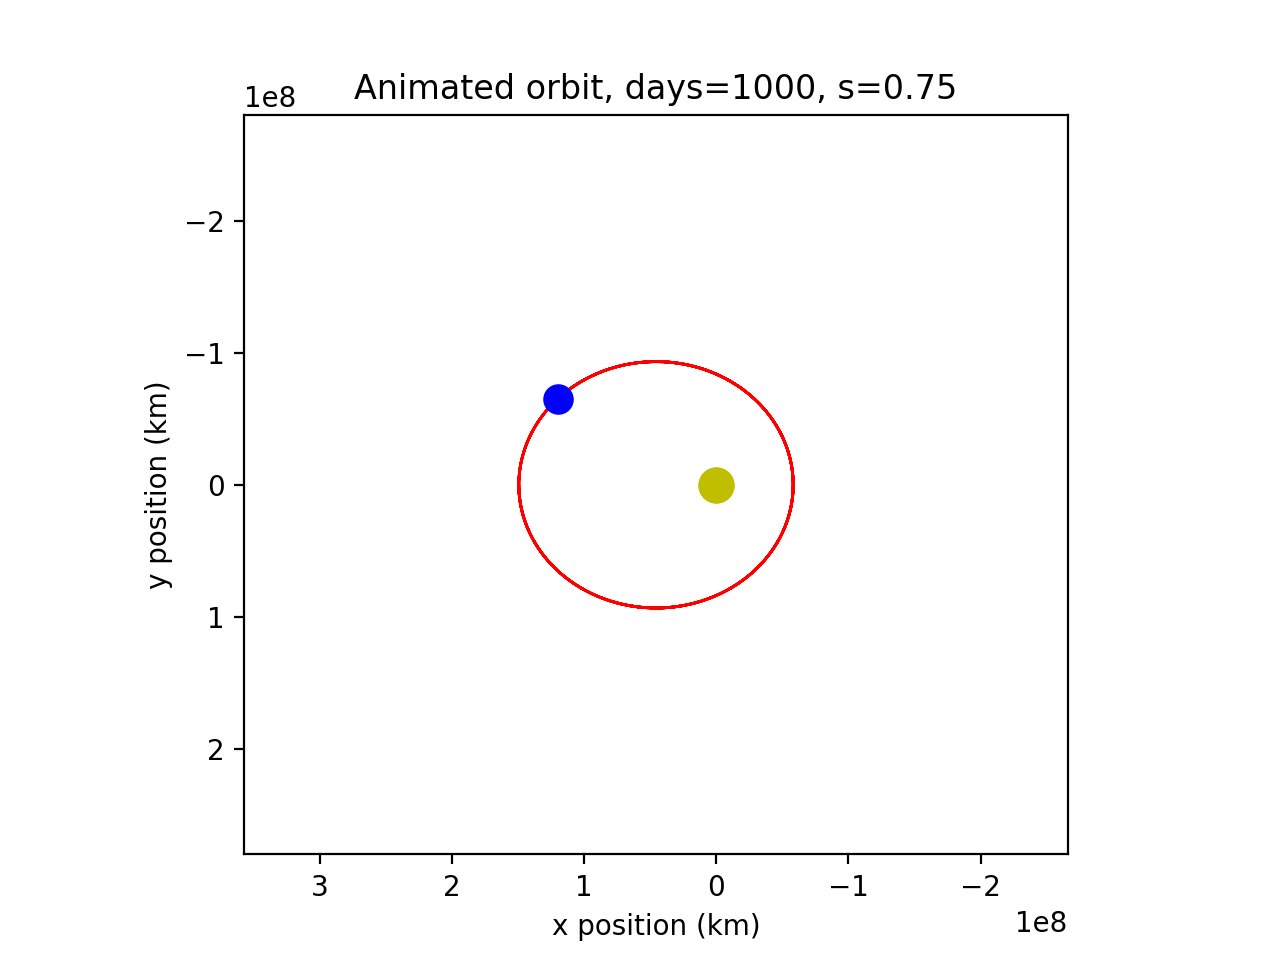

Creating animation for speed=1.00


<IPython.core.display.Javascript object>


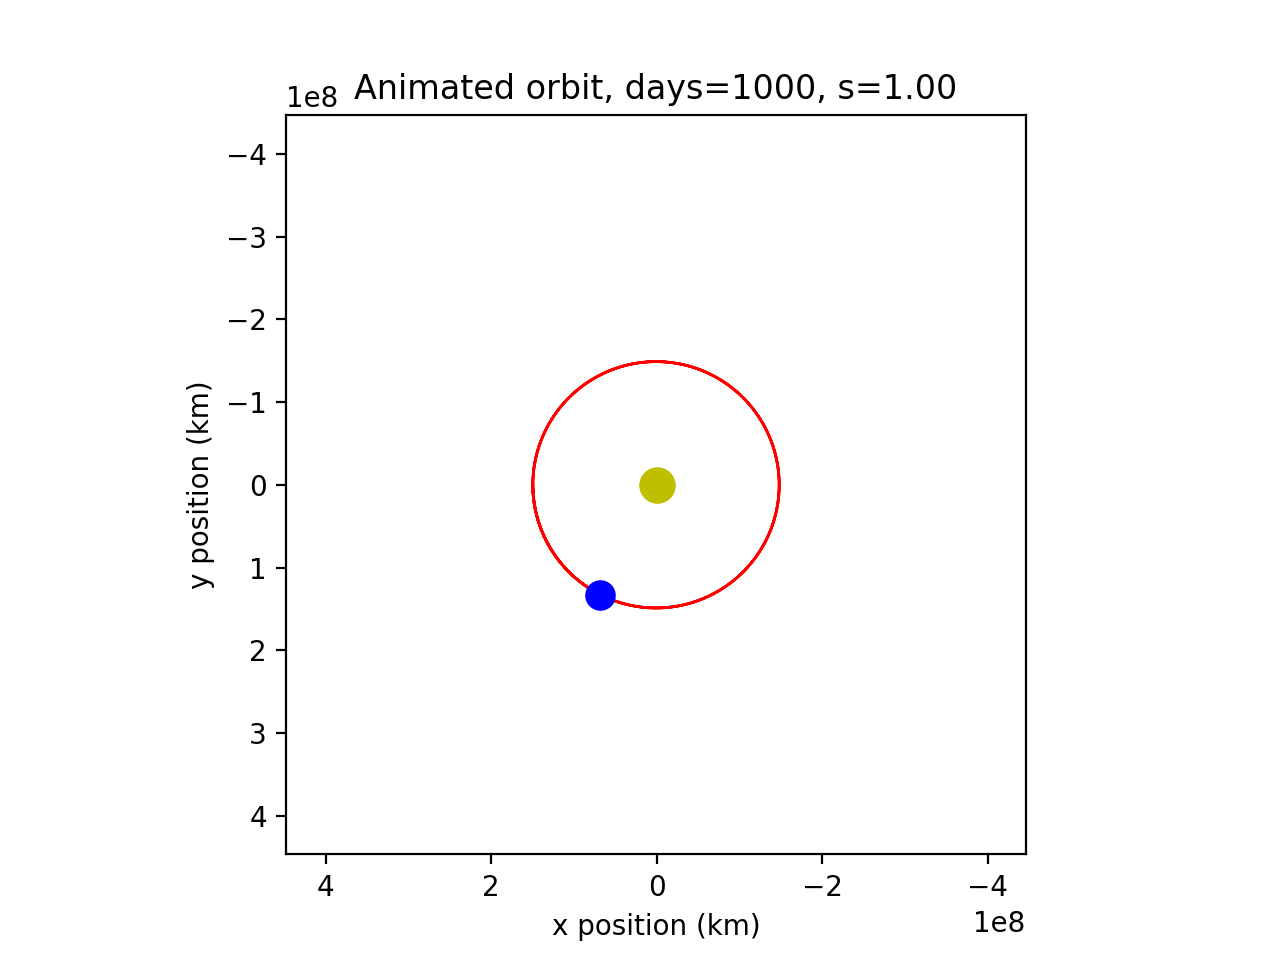

Creating animation for speed=1.25


<IPython.core.display.Javascript object>


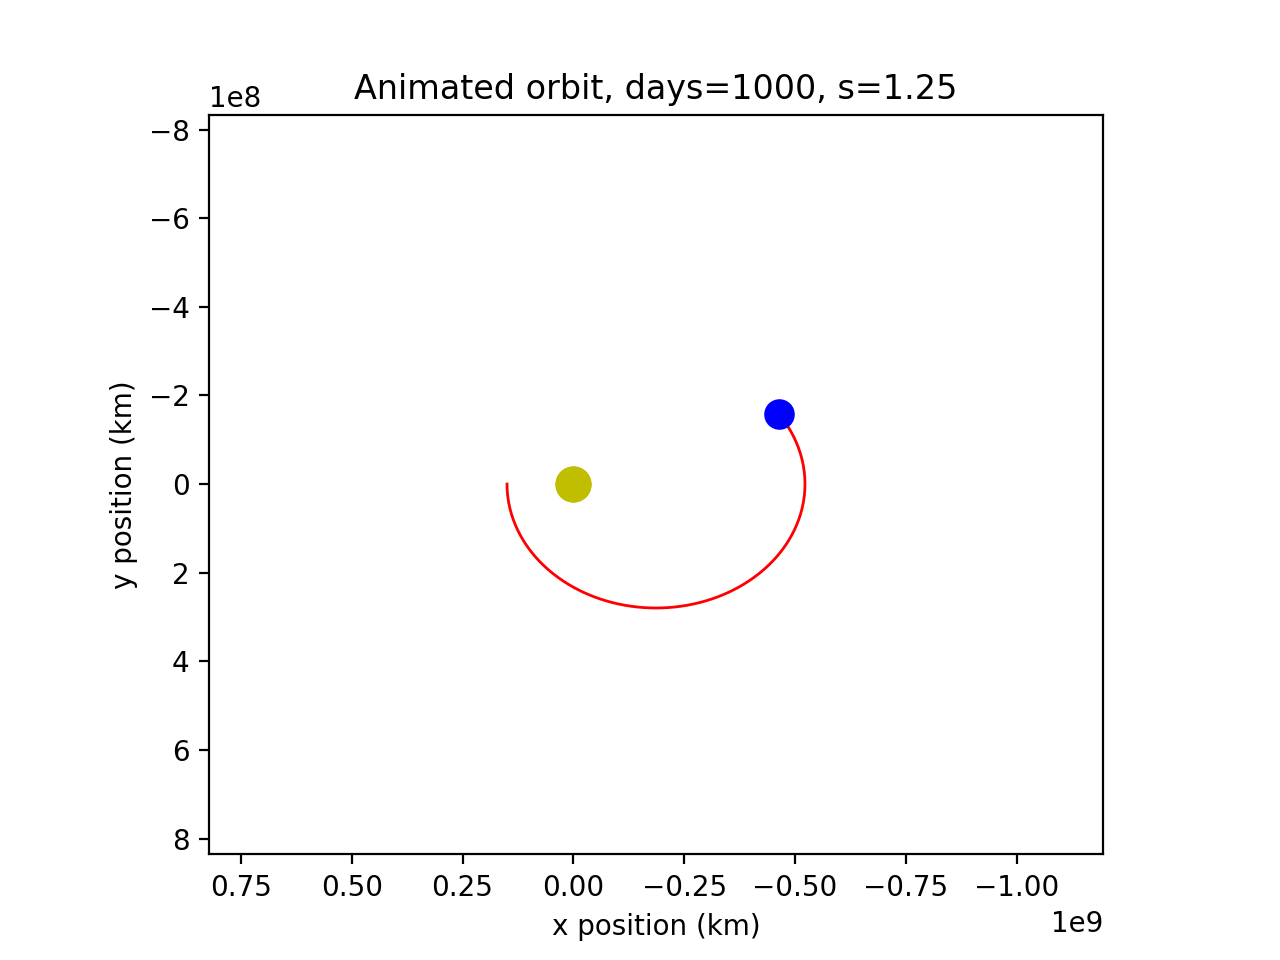

Creating animation for speed=1.50


<IPython.core.display.Javascript object>


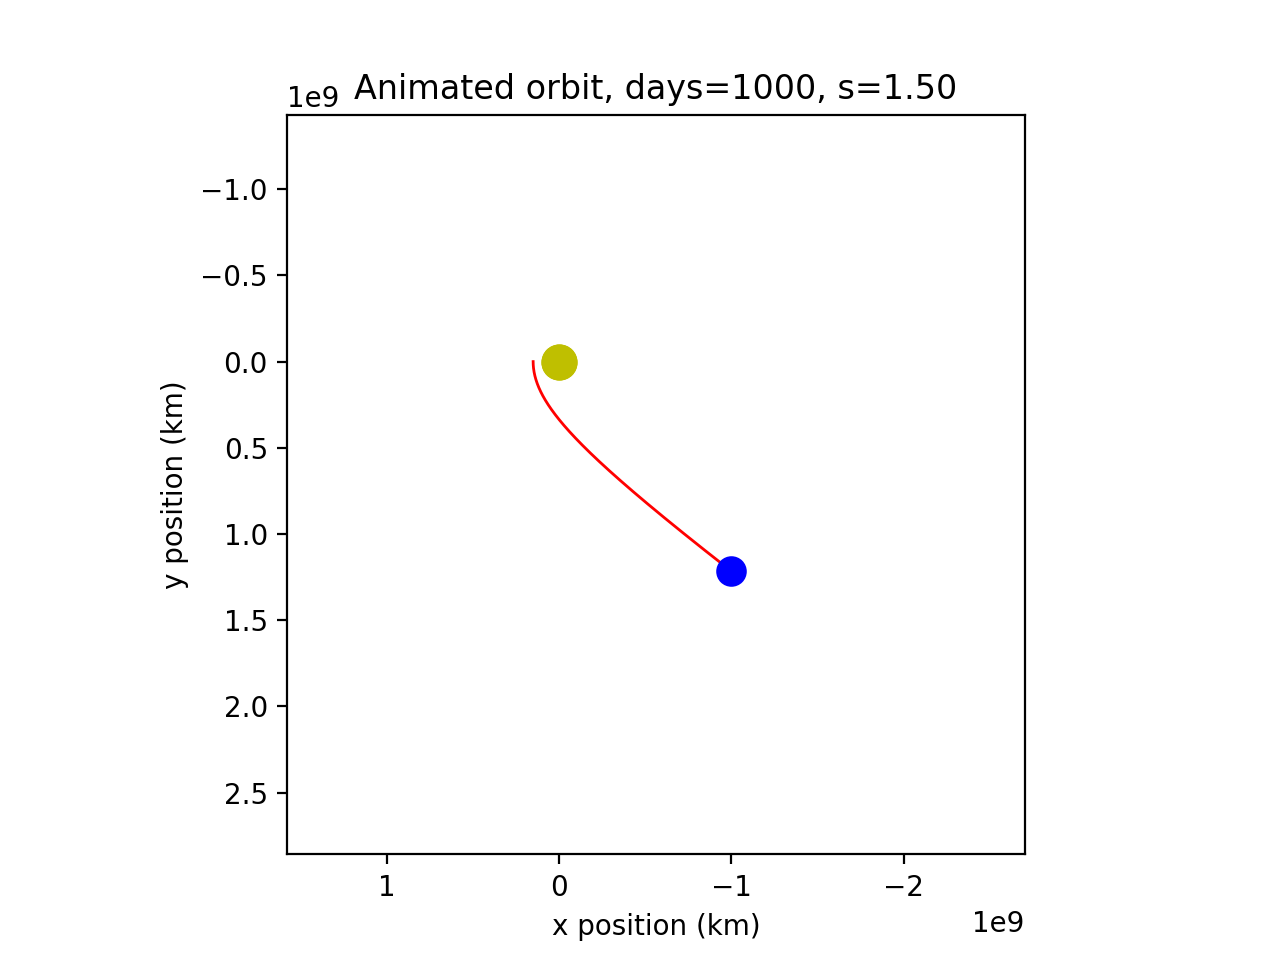

Done


In [12]:
def test_animate_earth_orbit():
    """ Test animate_earth_orbit() """
    
    print("Creating animation for speed=0.75")
    handle1 = animate_earth_orbit(ORBITS["075"], "Animated orbit, days=1000, s=0.75")
    
    print("Creating animation for speed=1.00")
    handle2 = animate_earth_orbit(ORBITS["100"], "Animated orbit, days=1000, s=1.00")
    
    print("Creating animation for speed=1.25")
    handle3 = animate_earth_orbit(ORBITS["125"], "Animated orbit, days=1000, s=1.25")
    
    print("Creating animation for speed=1.50")
    handle4 = animate_earth_orbit(ORBITS["150"], "Animated orbit, days=1000, s=1.50")
    print("Done")
        
    return handle1, handle2, handle3, handle4

%matplotlib notebook
# Save handles to animation objects so they are not garbage collected
HANDLES = test_animate_earth_orbit()

**Observations: Geometric shapes of the various orbits computed by simulations**

* The first and third plotted shapes follow more of an elliptical path.
* The second plot is that of a circular path (shown more precisely by modified aspect ratio).
* The fourth plot shows Earth in a hyperbolic orbit.

**When the earth's trajectory increased its initial velocity by 50%?**

The Earth's trajectory transitions into a hyperbolic orbit rather than an elliptical one, and as a result the Earth no longer orbits around the Sun.